<a href="https://colab.research.google.com/github/GEOM-HWH/Testing/blob/main/ML_Study_Graph_Classification_220816_%EC%88%98%EC%A0%95%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

버전 확인 후 설치를 위한 코드

In [1]:
import os
import torch

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

1.12.1+cu113


In [2]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 5.2 MB/s 
     |████████████████████████████████| 3.5 MB 3.2 MB/s 


Graph Neural Networks(GNNs)을 그래프 분류에 어떻게 적용할 수 있는지 확인.

그래프 분류란 주어진 그래프 데이터에 대해 각 그래프의 구조적 특성에 기반하여 그래프들을 분류하는 문제를 뜻함.

그래프를 embed(그래프를 벡터나 벡터 집합으로 변환)하여, 그래프 집합을 선형적으로 분류할 수 있도록 만들 수 있도록 embedding 하는것이 목표

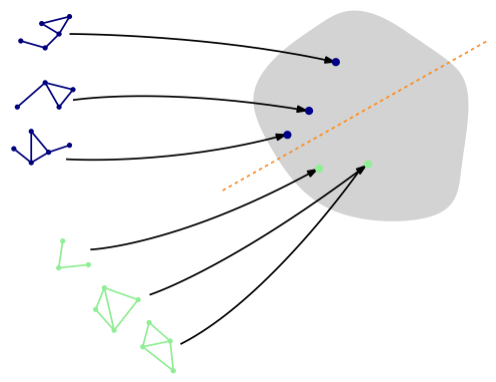

그래프 분류가 제일 많이 사용되는 분야는 분자 특성 예측

분자들은 graph로 표현될 수 있으며, 해당 분자가 HIV 바이러스의 복제를 예방할 수 있는지 유무 등을 판별할 때에 사용될 수 있음

TU Dortmund University는 TUDataset으로 알려진 넓은 범위의 다양한 그래프 분류 dataset을 수집해왔으며, torch_geometric.dataset을 통해 접근이 가능. 이 중 작은 데이터 셋인 MUTAG dataset을 살펴봅니다.

In [3]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset:{dataset}:')
print('===================')
print(f'Number of graphs:{len(dataset)}')
print(f'Number of features:{dataset.num_features}')
print(f'Number of classes:{dataset.num_classes}')


Dataset:MUTAG(188):
Number of graphs:188
Number of features:7
Number of classes:2


Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


MUTAG dataset 안에 있는 첫번째 data를 print해서 보고, 해당 data의 특성을 확인해보기

In [4]:
data = dataset[0]

print()
print(data)
print('=====================================================')

print(f'Number of nodes:{data.num_nodes}')
print(f'Number of edges:{data.num_edges}')
print(f'Average node degree:{data.num_edges/data.num_nodes:.2f}')
print(f'Has isolated nodes:{data.has_isolated_nodes()}')  # isolated nodes를 graph가 가지고 있으면 True 값을 반환
print(f'Has self-loops:{data.has_self_loops()}')
print(f'Is undirected:{data.is_undirected()}')


Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes:17
Number of edges:38
Average node degree:2.24
Has isolated nodes:False
Has self-loops:False
Is undirected:True


In [9]:
data.edge_attr

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.]])

undirected graph with no self-loop, has no isolated node

해당 dataset은 188개의 graph들로 구성되어 있으며, 각각의 그래프를 두 가지 class 중 하나의 class로 분류하는 것이 목표

첫 번째 데이터를 관찰해본 결과, 해당 그래프는 17개의 node(각 node는 7차원의 feature vector를 가짐)가 있으며, 38개의 edge를 가지고 있음(평균적인 node의 degree는 2.24). 또한 y=[1]로 하나의 그래프 라벨을 가지고 있음.



실습에서는 dataset을 shuffle 한 뒤, 앞에서부터 150개의 그래프를 training dataset, 나머지 그래프들을 test dataset으로 split

In [6]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs:{len(train_dataset)}')
print(f'Number of test graphs:{len(test_dataset)}')

Number of training graphs:150
Number of test graphs:38


# Mini-batching of graphs

GNN에 기존의 딥러닝 방식을 사용하기엔 적용가능성이 없거나 많은 메모리를 사용하게 된다(due to message passing). Pytorch geometric은 다른 방식들을 사용하여 learning을 진행하게 된다.

본 예시에서는, 인접 행렬들을 대각선으로 모두 쌓아, node와 target feature들을 node dimension으로 concatenate 하여 한꺼번에 learning을 진행하게 된다(mini-batch 별로 합쳐서 learning).

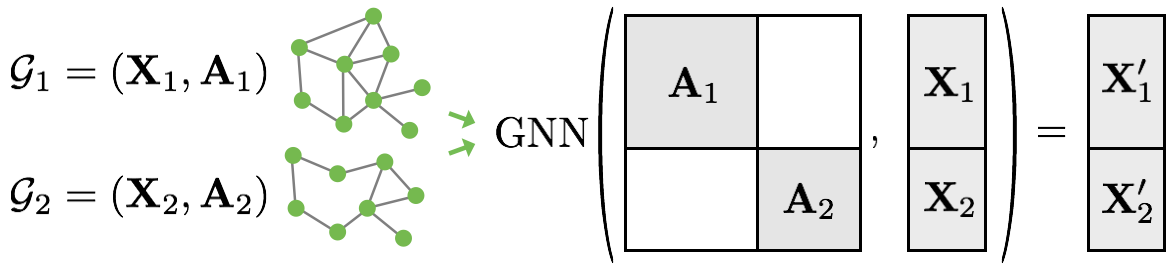

이런 과정은 다른 batching process에 비해 결정적인 장점들이 존재함 :

다른 그래프에 속해 있는 두 node들 간에는 message가 교환되지 않기 때문에, message passing에 의존하는 GNN operator들을 변형할 필요가 없다.

계산량이나 메모리 과부하를 방지할 수 있다.(변형된 adjacency matrix는 edge가 있는 non-zero entry들만 sparse하게 저장됨)

PyTorch Geometric는 이러한 multiple graphs의 batching을 torch_geometric.data.DataLoader class를 활용하여 자동으로 하나의 giant graph 형태로 변형해준다.

In [8]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
  print(f'Step {step+1}:')
  print('=======')
  print(f'Number of graphs in the current batch: {data.num_graphs}')
  print(data)
  print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2636], x=[1188, 7], edge_attr=[2636, 4], y=[64], batch=[1188], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2506], x=[1139, 7], edge_attr=[2506, 4], y=[64], batch=[1139], ptr=[65])

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 852], x=[387, 7], edge_attr=[852, 4], y=[22], batch=[387], ptr=[23])



batch size는 64로 진행, 3개의 (randomly shuffled) mini-batches, containing all  2⋅64+22=150  graphs.(64, 64, 22 개의 그래프가 각각의 batch에 들어감)

각각의 batch는 batch vector(배치 내의 각각의 그래프에 속한 node 별로 표시 - 0 그래프의 node들, 1 그래프의 node들, 2 그래프의 node들 ...)도 포함하고 있음

ex) batch=[0,…,0,1,…,1,2,…] 



GNN에서의 training

Training a GNN for graph classification :

1.여러번의 message passing 과정을 수행하면서 각 node를 embedding

2.node embedding을 합쳐 graph embedding(readout layer)

3.graph embedding으로 classifier를 training

readout layer는 다양한 형태가 존재하지만, 가장 평범한 형태는 node embedding의 평균을 취함

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric는 torch_geometric.nn.global_mean_pool를 통해 해당 작업을 수행, 이는 mini-batch 내의 모든 node들의 node embedding을 취하고 batch 내의 각각의 graph에 대해 [batch_size, hidden_channels] 사이즈의 graph embedding을 계산함



In [10]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
  def __init__(self,hidden_channels):
    super(GCN, self).__init__()
    torch.manual_seed(12345)
    self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, hidden_channels)
    self.conv3 = GCNConv(hidden_channels, hidden_channels)
    self.lin = Linear(hidden_channels, dataset.num_classes)

  def forward(self, x, edge_index, batch):
    # Obtain node embeddings
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = self.conv2(x, edge_index)
    x = x.relu()
    x = self.conv3(x, edge_index)

    x = global_mean_pool(x, batch)  # readout layer. [batch_size, hidden_channels]

    x = F.dropout(x, p=0.5, training=self.training)  # Apply a final classifier
    x = self.lin(x)

    return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [11]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0,true,{maxHeight:300})'''))

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
  model.train()

  for data in train_loader:
    out = model(data.x, data.edge_index, data.batch)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

def test(loader):
  model.eval()

  correct = 0
  for data in loader:
    out = model(data.x, data.edge_index, data.batch)
    pred = out.argmax(dim=1)
    correct += int((pred == data.y).sum())
  return correct/len(loader.dataset)

for epoch in range(1,171):
  train()
  train_acc = test(train_loader)
  test_acc = test(test_loader)
  print(f'Epoch: {epoch:03d}, Train Acc:{train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Acc:0.6467, Test Acc: 0.7368
Epoch: 002, Train Acc:0.6467, Test Acc: 0.7368
Epoch: 003, Train Acc:0.6467, Test Acc: 0.7368
Epoch: 004, Train Acc:0.6467, Test Acc: 0.7368
Epoch: 005, Train Acc:0.6467, Test Acc: 0.7368
Epoch: 006, Train Acc:0.6533, Test Acc: 0.7368
Epoch: 007, Train Acc:0.7467, Test Acc: 0.7632
Epoch: 008, Train Acc:0.7267, Test Acc: 0.7632
Epoch: 009, Train Acc:0.7200, Test Acc: 0.7632
Epoch: 010, Train Acc:0.7133, Test Acc: 0.7895
Epoch: 011, Train Acc:0.7200, Test Acc: 0.7632
Epoch: 012, Train Acc:0.7200, Test Acc: 0.7895
Epoch: 013, Train Acc:0.7200, Test Acc: 0.7895
Epoch: 014, Train Acc:0.7133, Test Acc: 0.8421
Epoch: 015, Train Acc:0.7133, Test Acc: 0.8421
Epoch: 016, Train Acc:0.7533, Test Acc: 0.7368
Epoch: 017, Train Acc:0.7400, Test Acc: 0.7632
Epoch: 018, Train Acc:0.7133, Test Acc: 0.8421
Epoch: 019, Train Acc:0.7400, Test Acc: 0.7895
Epoch: 020, Train Acc:0.7533, Test Acc: 0.7368
Epoch: 021, Train Acc:0.7467, Test Acc: 0.7895
Epoch: 022, T